[link text](https://)  
#  OM_P_label_oversampled

## Setup

In [1]:
!pip install "tensorflow-text>=2.10"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 116.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 42.7 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully 

In [2]:
import numpy as np
import typing
from typing import Any, Tuple
from sklearn.model_selection import train_test_split

import pathlib

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [3]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

#### Loading the Dataset

In [4]:
import pandas as pd
ORM_data = pd.read_csv('po_oversample_combined.csv')


In [5]:
ORM_data.head()

,OM_Regular,OM_Prediction,Unnamed: 2
0,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...,NaN
1,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...,NaN
2,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...,NaN
3,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...,NaN
4,moduleOM_nameonesigclass1_nameextendsClassattr...,moduleOM_nameonesigclass1_nameextendsClassattr...,NaN


In [6]:
OM_Regular = ORM_data['OM_Regular'].values
OM_Prediction = ORM_data['OM_Prediction'].values

In [7]:
X = OM_Regular
Y = OM_Prediction

#### Dividing data as Target and Context

In [8]:
target_raw =  Y
context_raw = X
print(context_raw[-1])

moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1oneparentparentinclass5_nameid=c3_at1isAbstract=No}onesigc2_at1extendsc2_at1_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at1extendsc3_at1_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_type,onesigclass5_nameextendsClassattrSet=c5_at1+c3_at1id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_type,onesigclass7_nam

In [9]:
print(target_raw[-1])

moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1oneparentparentinclass5_nameid=c3_at1isAbstract=No}onesigc2_at1extendsc2_at1_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at1extendsc3_at1_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_type,onesigclass5_nameextendsClassattrSet=c5_at1+c3_at1id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_type,onesigclass7_nam

### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [10]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 1

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [11]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor([b'moduleOM_nameonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2attrSet=c1_at1+c1_at2isAbstract=Nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassid=IntegerisAbstract=Nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsClassattrSet=c3_at1oneparentparentinclass1_nameisAbstract=NoattrSet=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,OM_name_Solution:1Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at2:c1_at2_typeTable:class3_nameAttributec3_at1:c3_at1_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec1_at1:c1_at1_typeForeignKeyTable:class3_nameParentClassclass1_nameTableName:class1_nameTableName:class2_nameTableName:class3_nameAssociationTableassoc1

### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation, We may or may not decide to Use this for ORM data. I kept it in the experiment

In [12]:
example_text = tf.constant('moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,​OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc1`(`c5_at1`c5_at1_type`c1_at1`c1_at1_typeKEY`FK_assoc1_c5_at1_idx`(`c5_at1`)KEY`FK_assoc1_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c5_at1``c1_at1`));----CREATETABLE`assoc3``c5_at1`c5_at1_type`c4_at1`c4_at1_typeKEY`FK_assoc3_c5_at1_idx`(`c5_at1`)KEY`FK_assoc3_c4_at1_idx`(`c4_at1`)PRIMARYKEY(`c5_at1``c4_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type`c5_at1`c5_at1_typePRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type`c3_at1`c3_at1_typeNOTNULLPRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type`c2_at1`c2_at1_typePRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_typePRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_typePRIMARYKEY(`c1_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type`c6_at3`c6_at3_type`c6_at2`c6_at2_type`c6_at1`c6_at1_typeNOTNULLPRIMARYKEY(`c6_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type`c2_at1`c2_at1_typeKEY`FK_assoc2_c5_at1_idx`(`c5_at1`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c5_at1``c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc5_c3_at1_idx`(`c3_at1`)KEY`FK_assoc5_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1``c2_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc4_c6_at1_idx`(`c6_at1`)KEY`FK_assoc4_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c6_at1``c2_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE')

#example_text = tf.constant('class1,table2,obj1,atr1')
print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparen

In [13]:
#import re

#def tf_lower_and_split_punct(text):
  # Split accented characters.
  #text = tf_text.normalize_utf8(text, 'NFKD')
  #text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  #pattern = '\s+'
  #re.split(pattern, text, maxsplit=2)
  #text = tf.strings.regex_replace(text, '\s+', '')
  #tf.strings.split(text, sep=', ', maxsplit=2, name=None)
  #tf.strings.split (text, sep='\s+', maxsplit=2, name=None)
  #text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  #tf.strings.split(text, ',')
  #text = tf.strings.split(text, sep=None, maxsplit=-1, name=None)
  #text.tf.strings.split(', ')

  # Add spaces around punctuation.
  #text = tf.strings.regex_replace(text, '', r'')
  # Strip whitespace.
  #text = tf.strings.strip(text)

  #text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  #return text


def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '', r'\0')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [14]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparenti

#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [15]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [16]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:50]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['',
 '[UNK]',
 '[START]',
 '[END]',
 'moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2ex

That's the context data  `TextVectorization` layer, now build and `.adapt()` for the Target Data one:

In [17]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:50]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2ex

Now these layers can convert a batch of strings into a batch of token IDs:

In [18]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 25, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [19]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] moduleom_nameonesigclass1_nameextendsclassattrset=c1_at1+c1_at2attrset=c1_at1+c1_at2isabstract=nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassid=integerisabstract=nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsassociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsclassattrset=c3_at1oneparentparentinclass1_nameisabstract=noattrset=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,om_name_solution:1table:class1_nameattributec1_at1:c1_at1_typeprimarykeytable:class1_nameattributec1_at2:c1_at2_typetable:class2_nameattributec2_at2:c1_at2_typetable:class3_nameattributec3_at1:c3_at1_typetable:class1_nameattributec1_at1:c1_at1_typeprimarykeytable:class3_nameattributec1_at1:c1_at1_typeforeignkeytable:class3_nameparentclassclass1_nametablename:class1_nametablename:class2_nametablename:class3_nameassociationtableassoc1sour

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

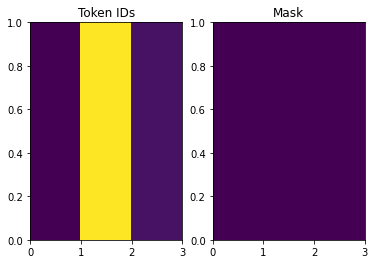

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [21]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [22]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[ 2 18  3]

[ 2 19]
[19  3]


## The encoder/decoder

  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [23]:
UNITS = 256

### The encoder


The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [24]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [25]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (1, 3)
Encoder output, shape (batch, s, units): (1, 3, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 


In [26]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
       query=x,
       value=context,
      return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
  #Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [27]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                 output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (1, 3, 256)
Target sequence, shape (batch, t, units): (1, 2, 256)
Attention result, shape (batch, t, units): (1, 2, 256)
Attention weights, shape (batch, t, s):    (1, 2, 3)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [28]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1., 1.], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

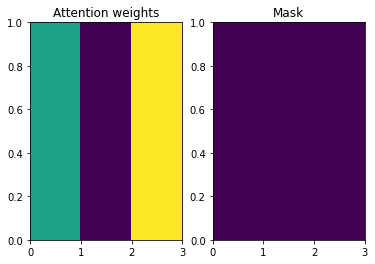

In [29]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.


Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [30]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [31]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [32]:
decoder = Decoder(target_text_processor, UNITS)

Decoder usage

In [33]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (1, 3, 256)
input target tokens shape: (batch, t) (1, 2)
logits shape shape: (batch, target_vocabulary_size) (1, 2, 171)


#### Inference

For inference usage couple more methods.

In [34]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [35]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [36]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [37]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'moduleom_name:0,opendeclarationonesigclass1_nameextendsclassattrset=c1_at1id=c1_at1isabstract=nonoparent}onesigc1_at1extendsc1_at1_type,onesigclass01_nameextendsclassattrset=c01_at1id=c01_at1isabstract=nonoparent}onesigc01_at1extendsc01_at1_type,onesigassoc1extendsassociationsrc=class1_namedst=class01_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass2_nameextendsclassattrset=c2_at1id=c2_at1isabstract=nonoparent}onesigc2_at1extendsc2_at1_type,onesigassoc2extendsassociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1isabstract=nonoparent}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_type,onesigclass4_nameextendsclassattrset=c4_at1oneparentid=c3_at1isabstract=noparentinclass3_name}onesigc4_at1extendsc4_at1_type,onesigassoc3extendsassociationdst=class2_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigclass5_nameextendsclassattrset



```
# This is formatted as code
```

**Since the model's untrained, it outputs items from the vocabulary almost uniformly at random. **

## The model


In [38]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [39]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (1, 3)
Target tokens, shape: (batch, t) (1, 2)
logits, shape: (batch, t, target_vocabulary_size) (1, 2, 171)


### Train

In [40]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [41]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [42]:
model.compile(optimizer='Adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [43]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 5.1416636, 'expected_acc': 0.005847953216374269}

That should roughly match the values returned by running a few steps of evaluation:

In [44]:
model.evaluate(val_ds, steps=60, return_dict=True)

47/60 [======================>.......] - ETA: 0s - loss: 5.2678 - masked_acc: 0.0000e+00 - masked_loss: 5.2678

60/60 [==============================] - 8s 15ms/step - loss: 5.2625 - masked_acc: 0.0000e+00 - masked_loss: 5.2625


{'loss': 5.262463092803955,
 'masked_acc': 0.0,
 'masked_loss': 5.262463092803955}

In [45]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 60,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 3.2579 - masked_acc: 0.4900 - masked_loss: 3.2579

100/100 [==============================] - 17s 29ms/step - loss: 3.2579 - masked_acc: 0.4900 - masked_loss: 3.2579 - val_loss: 3.1222 - val_masked_acc: 0.5000 - val_masked_loss: 3.1222
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 3.2869 - masked_acc: 0.5000 - masked_loss: 3.2869

100/100 [==============================] - 2s 24ms/step - loss: 3.2869 - masked_acc: 0.5000 - masked_loss: 3.2869
Epoch 3/100
 98/100 [============================>.] - ETA: 0s - loss: 3.1652 - masked_acc: 0.5051 - masked_loss: 3.1652

100/100 [==============================] - 2s 24ms/step - loss: 3.1586 - masked_acc: 0.5050 - masked_loss: 3.1586
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 2.8572 - masked_acc: 0.5051 - masked_loss: 2.8572

100/100 [==============================] - 2s 24ms/step - loss: 2.8534 - masked_acc: 0.5050 - masked_loss: 2.8534
Epoch 5/100
100/100 [==============================] - ETA: 0s - loss: 2.9647 - masked_acc: 0.5050 - masked_loss: 2.9647

100/100 [==============================] - 2s 23ms/step - loss: 2.9647 - masked_acc: 0.5050 - masked_loss: 2.9647
Epoch 6/100
 99/100 [============================>.] - ETA: 0s - loss: 2.5841 - masked_acc: 0.5101 - masked_loss: 2.5841

100/100 [==============================] - 2s 24ms/step - loss: 2.5849 - masked_acc: 0.5100 - masked_loss: 2.5849
Epoch 7/100
 99/100 [============================>.] - ETA: 0s - loss: 2.6392 - masked_acc: 0.5101 - masked_loss: 2.6392

100/100 [==============================] - 3s 26ms/step - loss: 2.6430 - masked_acc: 0.5100 - masked_loss: 2.6430
Epoch 8/100
 98/100 [============================>.] - ETA: 0s - loss: 2.4575 - masked_acc: 0.5102 - masked_loss: 2.4575

100/100 [==============================] - 2s 24ms/step - loss: 2.4626 - masked_acc: 0.5100 - masked_loss: 2.4626
Epoch 9/100
 99/100 [============================>.] - ETA: 0s - loss: 2.2934 - masked_acc: 0.5354 - masked_loss: 2.2934

100/100 [==============================] - 2s 24ms/step - loss: 2.2948 - masked_acc: 0.5350 - masked_loss: 2.2948
Epoch 10/100
 98/100 [============================>.] - ETA: 0s - loss: 2.5428 - masked_acc: 0.5102 - masked_loss: 2.5428

100/100 [==============================] - 2s 24ms/step - loss: 2.5507 - masked_acc: 0.5100 - masked_loss: 2.5507
Epoch 11/100
 98/100 [============================>.] - ETA: 0s - loss: 2.1526 - masked_acc: 0.5204 - masked_loss: 2.1526

100/100 [==============================] - 2s 24ms/step - loss: 2.1607 - masked_acc: 0.5200 - masked_loss: 2.1607
Epoch 12/100
 99/100 [============================>.] - ETA: 0s - loss: 2.2091 - masked_acc: 0.5455 - masked_loss: 2.2091

100/100 [==============================] - 2s 24ms/step - loss: 2.2130 - masked_acc: 0.5450 - masked_loss: 2.2130
Epoch 13/100
100/100 [==============================] - ETA: 0s - loss: 2.1383 - masked_acc: 0.5650 - masked_loss: 2.1383

100/100 [==============================] - 2s 23ms/step - loss: 2.1383 - masked_acc: 0.5650 - masked_loss: 2.1383
Epoch 14/100
 98/100 [============================>.] - ETA: 0s - loss: 1.9988 - masked_acc: 0.5408 - masked_loss: 1.9988

100/100 [==============================] - 2s 23ms/step - loss: 2.0224 - masked_acc: 0.5400 - masked_loss: 2.0224
Epoch 15/100
 98/100 [============================>.] - ETA: 0s - loss: 2.1060 - masked_acc: 0.5459 - masked_loss: 2.1060

100/100 [==============================] - 2s 24ms/step - loss: 2.0865 - masked_acc: 0.5500 - masked_loss: 2.0865
Epoch 16/100
 99/100 [============================>.] - ETA: 0s - loss: 1.7381 - masked_acc: 0.5859 - masked_loss: 1.7381

100/100 [==============================] - 2s 24ms/step - loss: 1.7547 - masked_acc: 0.5850 - masked_loss: 1.7547
Epoch 17/100
 98/100 [============================>.] - ETA: 0s - loss: 2.0159 - masked_acc: 0.5306 - masked_loss: 2.0159

100/100 [==============================] - 2s 23ms/step - loss: 2.0072 - masked_acc: 0.5350 - masked_loss: 2.0072
Epoch 18/100
 99/100 [============================>.] - ETA: 0s - loss: 1.8582 - masked_acc: 0.5808 - masked_loss: 1.8582

100/100 [==============================] - 2s 23ms/step - loss: 1.8439 - masked_acc: 0.5850 - masked_loss: 1.8439
Epoch 19/100
 99/100 [============================>.] - ETA: 0s - loss: 1.7724 - masked_acc: 0.5909 - masked_loss: 1.7724

100/100 [==============================] - 2s 25ms/step - loss: 1.7716 - masked_acc: 0.5900 - masked_loss: 1.7716
Epoch 20/100
 98/100 [============================>.] - ETA: 0s - loss: 1.6750 - masked_acc: 0.6020 - masked_loss: 1.6750

100/100 [==============================] - 2s 24ms/step - loss: 1.6683 - masked_acc: 0.6050 - masked_loss: 1.6683
Epoch 21/100
 99/100 [============================>.] - ETA: 0s - loss: 1.5850 - masked_acc: 0.6061 - masked_loss: 1.5850

100/100 [==============================] - 2s 24ms/step - loss: 1.5773 - masked_acc: 0.6050 - masked_loss: 1.5773
Epoch 22/100
100/100 [==============================] - ETA: 0s - loss: 1.5883 - masked_acc: 0.6200 - masked_loss: 1.5883

100/100 [==============================] - 2s 24ms/step - loss: 1.5883 - masked_acc: 0.6200 - masked_loss: 1.5883
Epoch 23/100
 99/100 [============================>.] - ETA: 0s - loss: 1.4210 - masked_acc: 0.6414 - masked_loss: 1.4210

100/100 [==============================] - 2s 24ms/step - loss: 1.4224 - masked_acc: 0.6400 - masked_loss: 1.4224
Epoch 24/100
 99/100 [============================>.] - ETA: 0s - loss: 1.3885 - masked_acc: 0.6414 - masked_loss: 1.3885

100/100 [==============================] - 2s 25ms/step - loss: 1.3881 - masked_acc: 0.6400 - masked_loss: 1.3881
Epoch 25/100
 99/100 [============================>.] - ETA: 0s - loss: 1.4534 - masked_acc: 0.6566 - masked_loss: 1.4534

100/100 [==============================] - 3s 26ms/step - loss: 1.4438 - masked_acc: 0.6600 - masked_loss: 1.4438
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 1.2445 - masked_acc: 0.6600 - masked_loss: 1.2445

100/100 [==============================] - 2s 25ms/step - loss: 1.2445 - masked_acc: 0.6600 - masked_loss: 1.2445
Epoch 27/100
100/100 [==============================] - ETA: 0s - loss: 1.3842 - masked_acc: 0.6250 - masked_loss: 1.3842

100/100 [==============================] - 3s 25ms/step - loss: 1.3842 - masked_acc: 0.6250 - masked_loss: 1.3842
Epoch 28/100
100/100 [==============================] - ETA: 0s - loss: 1.1897 - masked_acc: 0.7400 - masked_loss: 1.1897

100/100 [==============================] - 2s 24ms/step - loss: 1.1897 - masked_acc: 0.7400 - masked_loss: 1.1897
Epoch 29/100
100/100 [==============================] - ETA: 0s - loss: 0.9697 - masked_acc: 0.7250 - masked_loss: 0.9697

100/100 [==============================] - 2s 24ms/step - loss: 0.9697 - masked_acc: 0.7250 - masked_loss: 0.9697
Epoch 30/100
100/100 [==============================] - ETA: 0s - loss: 0.9611 - masked_acc: 0.7450 - masked_loss: 0.9611

100/100 [==============================] - 2s 24ms/step - loss: 0.9611 - masked_acc: 0.7450 - masked_loss: 0.9611
Epoch 31/100
 98/100 [============================>.] - ETA: 0s - loss: 0.8648 - masked_acc: 0.7704 - masked_loss: 0.8648

100/100 [==============================] - 2s 24ms/step - loss: 0.8712 - masked_acc: 0.7700 - masked_loss: 0.8712
Epoch 32/100
 99/100 [============================>.] - ETA: 0s - loss: 0.8839 - masked_acc: 0.7576 - masked_loss: 0.8839

100/100 [==============================] - 3s 30ms/step - loss: 0.8766 - masked_acc: 0.7600 - masked_loss: 0.8766
Epoch 33/100
100/100 [==============================] - ETA: 0s - loss: 0.9559 - masked_acc: 0.7550 - masked_loss: 0.9559

100/100 [==============================] - 4s 40ms/step - loss: 0.9559 - masked_acc: 0.7550 - masked_loss: 0.9559
Epoch 34/100
 98/100 [============================>.] - ETA: 0s - loss: 0.7238 - masked_acc: 0.7806 - masked_loss: 0.7238

100/100 [==============================] - 2s 24ms/step - loss: 0.7338 - masked_acc: 0.7750 - masked_loss: 0.7338
Epoch 35/100
100/100 [==============================] - ETA: 0s - loss: 0.7458 - masked_acc: 0.7650 - masked_loss: 0.7458

100/100 [==============================] - 2s 24ms/step - loss: 0.7458 - masked_acc: 0.7650 - masked_loss: 0.7458
Epoch 36/100
100/100 [==============================] - ETA: 0s - loss: 0.6959 - masked_acc: 0.7950 - masked_loss: 0.6959

100/100 [==============================] - 2s 24ms/step - loss: 0.6959 - masked_acc: 0.7950 - masked_loss: 0.6959
Epoch 37/100
 99/100 [============================>.] - ETA: 0s - loss: 0.6384 - masked_acc: 0.8182 - masked_loss: 0.6384

100/100 [==============================] - 2s 24ms/step - loss: 0.6427 - masked_acc: 0.8150 - masked_loss: 0.6427
Epoch 38/100
100/100 [==============================] - ETA: 0s - loss: 0.6228 - masked_acc: 0.8300 - masked_loss: 0.6228

100/100 [==============================] - 2s 24ms/step - loss: 0.6228 - masked_acc: 0.8300 - masked_loss: 0.6228
Epoch 39/100
 98/100 [============================>.] - ETA: 0s - loss: 0.4885 - masked_acc: 0.8367 - masked_loss: 0.4885

100/100 [==============================] - 2s 24ms/step - loss: 0.4842 - masked_acc: 0.8400 - masked_loss: 0.4842
Epoch 40/100
 98/100 [============================>.] - ETA: 0s - loss: 0.4977 - masked_acc: 0.8673 - masked_loss: 0.4977

100/100 [==============================] - 2s 24ms/step - loss: 0.5000 - masked_acc: 0.8650 - masked_loss: 0.5000
Epoch 41/100
 99/100 [============================>.] - ETA: 0s - loss: 0.5163 - masked_acc: 0.8535 - masked_loss: 0.5163

100/100 [==============================] - 2s 24ms/step - loss: 0.5114 - masked_acc: 0.8550 - masked_loss: 0.5114
Epoch 42/100
100/100 [==============================] - ETA: 0s - loss: 0.3808 - masked_acc: 0.8950 - masked_loss: 0.3808

100/100 [==============================] - 2s 24ms/step - loss: 0.3808 - masked_acc: 0.8950 - masked_loss: 0.3808
Epoch 43/100
100/100 [==============================] - ETA: 0s - loss: 0.4408 - masked_acc: 0.8700 - masked_loss: 0.4408

100/100 [==============================] - 2s 24ms/step - loss: 0.4408 - masked_acc: 0.8700 - masked_loss: 0.4408
Epoch 44/100
 98/100 [============================>.] - ETA: 0s - loss: 0.2470 - masked_acc: 0.9541 - masked_loss: 0.2470

100/100 [==============================] - 3s 26ms/step - loss: 0.2510 - masked_acc: 0.9500 - masked_loss: 0.2510
Epoch 45/100
 99/100 [============================>.] - ETA: 0s - loss: 0.3275 - masked_acc: 0.9091 - masked_loss: 0.3275

100/100 [==============================] - 2s 24ms/step - loss: 0.3247 - masked_acc: 0.9100 - masked_loss: 0.3247
Epoch 46/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2958 - masked_acc: 0.9343 - masked_loss: 0.2958

100/100 [==============================] - 2s 24ms/step - loss: 0.2930 - masked_acc: 0.9350 - masked_loss: 0.2930
Epoch 47/100
100/100 [==============================] - ETA: 0s - loss: 0.2105 - masked_acc: 0.9600 - masked_loss: 0.2105

100/100 [==============================] - 2s 24ms/step - loss: 0.2105 - masked_acc: 0.9600 - masked_loss: 0.2105
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 0.2097 - masked_acc: 0.9550 - masked_loss: 0.2097

100/100 [==============================] - 2s 24ms/step - loss: 0.2097 - masked_acc: 0.9550 - masked_loss: 0.2097
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 0.1125 - masked_acc: 0.9800 - masked_loss: 0.1125

100/100 [==============================] - 2s 23ms/step - loss: 0.1125 - masked_acc: 0.9800 - masked_loss: 0.1125
Epoch 50/100
100/100 [==============================] - ETA: 0s - loss: 0.1050 - masked_acc: 0.9900 - masked_loss: 0.1050

100/100 [==============================] - 2s 24ms/step - loss: 0.1050 - masked_acc: 0.9900 - masked_loss: 0.1050
Epoch 51/100
100/100 [==============================] - ETA: 0s - loss: 0.0992 - masked_acc: 0.9900 - masked_loss: 0.0992

100/100 [==============================] - 2s 24ms/step - loss: 0.0992 - masked_acc: 0.9900 - masked_loss: 0.0992
Epoch 52/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0673 - masked_acc: 0.9898 - masked_loss: 0.0673

100/100 [==============================] - 2s 24ms/step - loss: 0.0663 - masked_acc: 0.9900 - masked_loss: 0.0663
Epoch 53/100
100/100 [==============================] - ETA: 0s - loss: 0.0609 - masked_acc: 0.9950 - masked_loss: 0.0609

100/100 [==============================] - 2s 25ms/step - loss: 0.0609 - masked_acc: 0.9950 - masked_loss: 0.0609
Epoch 54/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0679 - masked_acc: 0.9898 - masked_loss: 0.0679

100/100 [==============================] - 2s 24ms/step - loss: 0.0669 - masked_acc: 0.9900 - masked_loss: 0.0669
Epoch 55/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0589 - masked_acc: 0.9898 - masked_loss: 0.0589

100/100 [==============================] - 2s 24ms/step - loss: 0.0581 - masked_acc: 0.9900 - masked_loss: 0.0581
Epoch 56/100
100/100 [==============================] - ETA: 0s - loss: 0.0617 - masked_acc: 0.9900 - masked_loss: 0.0617

100/100 [==============================] - 3s 26ms/step - loss: 0.0617 - masked_acc: 0.9900 - masked_loss: 0.0617
Epoch 57/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0350 - masked_acc: 0.9949 - masked_loss: 0.0350

100/100 [==============================] - 2s 24ms/step - loss: 0.0348 - masked_acc: 0.9950 - masked_loss: 0.0348
Epoch 58/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0778 - masked_acc: 0.9847 - masked_loss: 0.0778

100/100 [==============================] - 2s 24ms/step - loss: 0.0765 - masked_acc: 0.9850 - masked_loss: 0.0765
Epoch 59/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0331 - masked_acc: 0.9949 - masked_loss: 0.0331

100/100 [==============================] - 2s 23ms/step - loss: 0.0326 - masked_acc: 0.9950 - masked_loss: 0.0326
Epoch 60/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0693 - masked_acc: 0.9848 - masked_loss: 0.0693

100/100 [==============================] - 2s 24ms/step - loss: 0.0686 - masked_acc: 0.9850 - masked_loss: 0.0686
Epoch 61/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0627 - masked_acc: 0.9848 - masked_loss: 0.0627

100/100 [==============================] - 2s 24ms/step - loss: 0.0622 - masked_acc: 0.9850 - masked_loss: 0.0622
Epoch 62/100
100/100 [==============================] - ETA: 0s - loss: 0.0270 - masked_acc: 0.9950 - masked_loss: 0.0270

100/100 [==============================] - 2s 24ms/step - loss: 0.0270 - masked_acc: 0.9950 - masked_loss: 0.0270
Epoch 63/100
100/100 [==============================] - ETA: 0s - loss: 0.0666 - masked_acc: 0.9850 - masked_loss: 0.0666

100/100 [==============================] - 2s 24ms/step - loss: 0.0666 - masked_acc: 0.9850 - masked_loss: 0.0666
Epoch 64/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0747 - masked_acc: 0.9798 - masked_loss: 0.0747

100/100 [==============================] - 2s 24ms/step - loss: 0.0741 - masked_acc: 0.9800 - masked_loss: 0.0741
Epoch 65/100
100/100 [==============================] - ETA: 0s - loss: 0.0549 - masked_acc: 0.9850 - masked_loss: 0.0549

100/100 [==============================] - 2s 25ms/step - loss: 0.0549 - masked_acc: 0.9850 - masked_loss: 0.0549
Epoch 66/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0500 - masked_acc: 0.9899 - masked_loss: 0.0500

100/100 [==============================] - 2s 25ms/step - loss: 0.0496 - masked_acc: 0.9900 - masked_loss: 0.0496
Epoch 67/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0400 - masked_acc: 0.9899 - masked_loss: 0.0400

100/100 [==============================] - 2s 24ms/step - loss: 0.0397 - masked_acc: 0.9900 - masked_loss: 0.0397
Epoch 68/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0971 - masked_acc: 0.9747 - masked_loss: 0.0971

100/100 [==============================] - 2s 23ms/step - loss: 0.0961 - masked_acc: 0.9750 - masked_loss: 0.0961
Epoch 69/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0665 - masked_acc: 0.9798 - masked_loss: 0.0665

100/100 [==============================] - 3s 26ms/step - loss: 0.0659 - masked_acc: 0.9800 - masked_loss: 0.0659
Epoch 70/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0670 - masked_acc: 0.9798 - masked_loss: 0.0670

100/100 [==============================] - 2s 24ms/step - loss: 0.0664 - masked_acc: 0.9800 - masked_loss: 0.0664
Epoch 71/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0100 - masked_acc: 1.0000 - masked_loss: 0.0100

100/100 [==============================] - 2s 24ms/step - loss: 0.0100 - masked_acc: 1.0000 - masked_loss: 0.0100
Epoch 72/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0436 - masked_acc: 0.9898 - masked_loss: 0.0436

100/100 [==============================] - 2s 24ms/step - loss: 0.0429 - masked_acc: 0.9900 - masked_loss: 0.0429
Epoch 73/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0577 - masked_acc: 0.9848 - masked_loss: 0.0577

100/100 [==============================] - 2s 24ms/step - loss: 0.0572 - masked_acc: 0.9850 - masked_loss: 0.0572
Epoch 74/100
100/100 [==============================] - ETA: 0s - loss: 0.0656 - masked_acc: 0.9850 - masked_loss: 0.0656

100/100 [==============================] - 2s 24ms/step - loss: 0.0656 - masked_acc: 0.9850 - masked_loss: 0.0656
Epoch 75/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0742 - masked_acc: 0.9798 - masked_loss: 0.0742

100/100 [==============================] - 2s 24ms/step - loss: 0.0862 - masked_acc: 0.9750 - masked_loss: 0.0862
Epoch 76/100
 99/100 [============================>.] - ETA: 0s - loss: 1.0531 - masked_acc: 0.7980 - masked_loss: 1.0531

100/100 [==============================] - 2s 24ms/step - loss: 1.1255 - masked_acc: 0.7900 - masked_loss: 1.1255
Epoch 77/100
 98/100 [============================>.] - ETA: 0s - loss: 1.4921 - masked_acc: 0.6582 - masked_loss: 1.4921

100/100 [==============================] - 2s 24ms/step - loss: 1.4805 - masked_acc: 0.6550 - masked_loss: 1.4805
Epoch 78/100
100/100 [==============================] - ETA: 0s - loss: 0.9598 - masked_acc: 0.7200 - masked_loss: 0.9598

100/100 [==============================] - 2s 24ms/step - loss: 0.9598 - masked_acc: 0.7200 - masked_loss: 0.9598
Epoch 79/100
100/100 [==============================] - ETA: 0s - loss: 0.5891 - masked_acc: 0.8050 - masked_loss: 0.5891

100/100 [==============================] - 2s 25ms/step - loss: 0.5891 - masked_acc: 0.8050 - masked_loss: 0.5891
Epoch 80/100
 99/100 [============================>.] - ETA: 0s - loss: 0.5379 - masked_acc: 0.8283 - masked_loss: 0.5379

100/100 [==============================] - 2s 24ms/step - loss: 0.5341 - masked_acc: 0.8300 - masked_loss: 0.5341
Epoch 81/100
 98/100 [============================>.] - ETA: 0s - loss: 0.4205 - masked_acc: 0.8776 - masked_loss: 0.4205

100/100 [==============================] - 3s 25ms/step - loss: 0.4131 - masked_acc: 0.8800 - masked_loss: 0.4131
Epoch 82/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1671 - masked_acc: 0.9646 - masked_loss: 0.1671

100/100 [==============================] - 2s 24ms/step - loss: 0.1655 - masked_acc: 0.9650 - masked_loss: 0.1655
Epoch 83/100
100/100 [==============================] - ETA: 0s - loss: 0.0958 - masked_acc: 0.9750 - masked_loss: 0.0958

100/100 [==============================] - 2s 24ms/step - loss: 0.0958 - masked_acc: 0.9750 - masked_loss: 0.0958
Epoch 84/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0864 - masked_acc: 0.9745 - masked_loss: 0.0864

100/100 [==============================] - 2s 24ms/step - loss: 0.0849 - masked_acc: 0.9750 - masked_loss: 0.0849
Epoch 85/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0588 - masked_acc: 0.9847 - masked_loss: 0.0588

100/100 [==============================] - 2s 24ms/step - loss: 0.0579 - masked_acc: 0.9850 - masked_loss: 0.0579
Epoch 86/100
100/100 [==============================] - ETA: 0s - loss: 0.0748 - masked_acc: 0.9750 - masked_loss: 0.0748

100/100 [==============================] - 2s 24ms/step - loss: 0.0748 - masked_acc: 0.9750 - masked_loss: 0.0748
Epoch 87/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0870 - masked_acc: 0.9747 - masked_loss: 0.0870

100/100 [==============================] - 2s 24ms/step - loss: 0.0862 - masked_acc: 0.9750 - masked_loss: 0.0862
Epoch 88/100
100/100 [==============================] - ETA: 0s - loss: 0.0096 - masked_acc: 1.0000 - masked_loss: 0.0096

100/100 [==============================] - 2s 24ms/step - loss: 0.0096 - masked_acc: 1.0000 - masked_loss: 0.0096
Epoch 89/100
100/100 [==============================] - ETA: 0s - loss: 0.0371 - masked_acc: 0.9900 - masked_loss: 0.0371

100/100 [==============================] - 2s 24ms/step - loss: 0.0371 - masked_acc: 0.9900 - masked_loss: 0.0371
Epoch 90/100
100/100 [==============================] - ETA: 0s - loss: 0.0669 - masked_acc: 0.9750 - masked_loss: 0.0669

100/100 [==============================] - 2s 24ms/step - loss: 0.0669 - masked_acc: 0.9750 - masked_loss: 0.0669
Epoch 91/100
100/100 [==============================] - ETA: 0s - loss: 0.0175 - masked_acc: 0.9950 - masked_loss: 0.0175

100/100 [==============================] - 2s 24ms/step - loss: 0.0175 - masked_acc: 0.9950 - masked_loss: 0.0175
Epoch 92/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0412 - masked_acc: 0.9848 - masked_loss: 0.0412

100/100 [==============================] - 2s 23ms/step - loss: 0.0408 - masked_acc: 0.9850 - masked_loss: 0.0408
Epoch 93/100
100/100 [==============================] - ETA: 0s - loss: 0.0565 - masked_acc: 0.9750 - masked_loss: 0.0565

100/100 [==============================] - 2s 25ms/step - loss: 0.0565 - masked_acc: 0.9750 - masked_loss: 0.0565
Epoch 94/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0302 - masked_acc: 0.9899 - masked_loss: 0.0302

100/100 [==============================] - 3s 25ms/step - loss: 0.0299 - masked_acc: 0.9900 - masked_loss: 0.0299
Epoch 95/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0616 - masked_acc: 0.9796 - masked_loss: 0.0616

100/100 [==============================] - 2s 24ms/step - loss: 0.0605 - masked_acc: 0.9800 - masked_loss: 0.0605
Epoch 96/100
100/100 [==============================] - ETA: 0s - loss: 0.0232 - masked_acc: 0.9950 - masked_loss: 0.0232

100/100 [==============================] - 2s 24ms/step - loss: 0.0232 - masked_acc: 0.9950 - masked_loss: 0.0232
Epoch 97/100
100/100 [==============================] - ETA: 0s - loss: 0.0502 - masked_acc: 0.9800 - masked_loss: 0.0502

100/100 [==============================] - 2s 24ms/step - loss: 0.0502 - masked_acc: 0.9800 - masked_loss: 0.0502
Epoch 98/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0316 - masked_acc: 0.9899 - masked_loss: 0.0316

100/100 [==============================] - 2s 24ms/step - loss: 0.0313 - masked_acc: 0.9900 - masked_loss: 0.0313
Epoch 99/100
 98/100 [============================>.] - ETA: 0s - loss: 0.0049 - masked_acc: 1.0000 - masked_loss: 0.0049

100/100 [==============================] - 2s 25ms/step - loss: 0.0049 - masked_acc: 1.0000 - masked_loss: 0.0049
Epoch 100/100
100/100 [==============================] - ETA: 0s - loss: 0.0594 - masked_acc: 0.9750 - masked_loss: 0.0594

100/100 [==============================] - 2s 25ms/step - loss: 0.0594 - masked_acc: 0.9750 - masked_loss: 0.0594


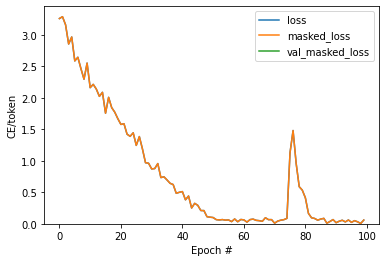

In [46]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['masked_loss'], label='masked_loss')
plt.plot(history.history['val_masked_loss'], label='val_masked_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

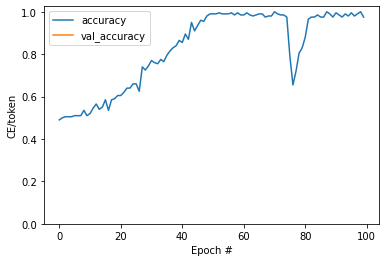

In [47]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [48]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [49]:
#sample Dataset Library_Management_Dataset_1_input_prerp_each_class_and_entitities_sep_experiment 



result1 = model.translate(['moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5+c3_at6id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_typeonesigc3_at6extendsc3_at6_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at3noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_type,onesigclass5_nameextendsClassattrSet=c5_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1_0+c6_at2+c6_at3+c6_at4id=c6_at2noparentisAbstract=No}onesigc6_at1_0extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_type,onesigclass7_nameextendsClassattrSet=c7_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc7_at1extendsc7_at1_type,onesigclass8_nameextendsClassattrSet=c8_at1+c8_at2+c2_at2+c6_at3id=c8_at1noparentisAbstract=No}onesigc8_at1extendsc8_at1_typeonesigc8_at1extendsc8_at1_type,onesigassoc1extendsAssociationsrc=class8_namedst=class2_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc2extendsAssociationsrc=class2_namedst=class4_name,src_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigassoc3extendsAssociationsrc=class8_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc4extendsAssociationsrc=class8_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc5extendsAssociationsrc=class8_namedst=class6_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc6extendsAssociationsrc=class6_namedst=class1_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc7extendsAssociationsrc=class6_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc8extendsAssociationsrc=class1_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc9extendsAssociationsrc=class1_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc10extendsAssociationsrc=class2_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,},MappingStrategyforclass1_name:map_str2MappingStrategyforclass5_name:map_str3MappingStrategyforclass7_name:map_str3AssociationStrategyforassoc1:assoc_str1AssociationStrategyforassoc3:assoc_str1AssociationStrategyforassoc4:assoc_str1AssociationStrategyforassoc7:assoc_str1AssociationStrategyforassoc8:assoc_str1AssociationStrategyforassoc9:assoc_str1AssociationStrategyforassoc10:assoc_str2AssociationStrategyforassoc5:assoc_str2AssociationStrategyforassoc6:assoc_str2,USEOM_name_0CREATETABLE`class3_name`(`c8_at1`c8_at1_type`c3_at6`c3_at6_type`c3_at5`c3_at5_type`c3_at4`c3_at4_type`c3_at3`c3_at3_type`c3_at2`c3_at2_typec3_at1`c3_at1_typeNOTNULLc1_at1`c1_at1_typeKEY`FK_class3_name_c8_at1_idx`(`c8_at1`)KEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c3_at1`),CREATETABLE`class1_name`(`c1_at1`c1_at2_type(64)`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64)`c8_at1`c8_at1_typec2_at1`c2_at1_typeNOTNULLKEY`FK_class2_name_c8_at1_idx`(`c8_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`class7_name`(`c7_at1`c7_at1_type(64)c2_at1`c2_at1_typeNOTNULLKEY`FK_class7_name_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`assoc10`(c3_at1`c3_at1_typeNOTNULLc2_at1`c2_at1_typeNOTNULLKEY`FK_assoc10_c3_at1_idx`(`c3_at1`)KEY`FK_assoc10_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1`,`c2_at1`),CREATETABLE`class8_name`(`c8_at2`c8_at2_type(64)`c6_at3`c6_at3_type(64)``c8_at1`c8_at1_typeNOTNULLPRIMARYKEY(`c8_at1`),CREATETABLE`class5_name`(`c5_at1`c5_at1_type,c2_at1`c2_at1_typeNOTNULLKEY`FK_class5_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c1_at1`),CREATETABLE`assoc5`(``c8_at1`c8_at1_typeNOTNULL`c2_at1`c2_at1_typeNOTNULLKEY`FK_assoc5_c8_at1_idx`(`c8_at1`),KEY`FK_assoc5_c6_at2_idx`(`c6_at2`)PRIMARYKEY(`c8_at1`,`c6_at2`),CREATETABLE`class4_name`(`c4_at4`c4_at4_type(64)`c4_at2`c4_at2_type(64)`c4_at1`c4_at1_type(64)`c8_at1`c8_at1_type`c6_at2`c6_at2_type`c4_at3`c4_at3_typec1_at1`c1_at1_typeKEY`FK_class4_name_c8_at1_idx`(`c8_at1`)KEY`FK_class4_name_c6_at2_idx`(`c6_at2`)KEY`FK_class4_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c4_at3`),CREATETABLE`assoc6`(`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULL`c3_at1`c3_at1_typeNOTNULLKEY`FK_assoc6_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c6_at2`,`c1_at1`),CREATETABLE`class6_name`(`c6_at4`c6_at4_type(64)`c6_at1_0`c6_at1_type`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c6_at2`),CREATETABLE`assoc2`(`c4_at3`c4_at3_typec2_at1`c2_at1_typeNOTNULLKEY`FK_assoc2_c4_at3_idx`(`c4_at3`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c4_at3`,`c2_at1`),ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`class7_name`ADDCONSTRAINT`FK_class2_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc10`ADDCONSTRAINT`FK_assoc10_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc10_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class5_nameADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class4_name`ADDCONSTRAINT`FK_class4_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c6_at2`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc6`ADDCONSTRAINT`FK_assoc6_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc6_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c4_at3`FOREIGNKEY(`c4_at3`)REFERENCES`class4_name`(`c4_at3`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,'])

result2 = model.translate(['moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5+c3_at6id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_typeonesigc3_at6extendsc3_at6_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at3noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_type,onesigclass5_nameextendsClassattrSet=c5_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1_0+c6_at2+c6_at3+c6_at4id=c6_at2noparentisAbstract=No}onesigc6_at1_0extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_type,onesigclass7_nameextendsClassattrSet=c7_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc7_at1extendsc7_at1_type,onesigclass8_nameextendsClassattrSet=c8_at1+c8_at2+c2_at2+c6_at3id=c8_at1noparentisAbstract=No}onesigc8_at1extendsc8_at1_typeonesigc8_at1extendsc8_at1_type,onesigassoc1extendsAssociationsrc=class8_namedst=class2_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc2extendsAssociationsrc=class2_namedst=class4_name,src_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigassoc3extendsAssociationsrc=class8_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc4extendsAssociationsrc=class8_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc5extendsAssociationsrc=class8_namedst=class6_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc6extendsAssociationsrc=class6_namedst=class1_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc7extendsAssociationsrc=class6_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc8extendsAssociationsrc=class1_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc9extendsAssociationsrc=class1_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc10extendsAssociationsrc=class2_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,},MappingStrategyforclass1_name:map_str2MappingStrategyforclass8_name:map_str2MappingStrategyforclass5_name:map_str3MappingStrategyforclass7_name:map_str3AssociationStrategyforassoc1:assoc_str1AssociationStrategyforassoc3:assoc_str1AssociationStrategyforassoc4:assoc_str1AssociationStrategyforassoc7:assoc_str1AssociationStrategyforassoc8:assoc_str1AssociationStrategyforassoc9:assoc_str1AssociationStrategyforassoc10:assoc_str2AssociationStrategyforassoc5:assoc_str2AssociationStrategyforassoc6:assoc_str2,USEOM_name_0CREATETABLE`class3_name`(`c8_at1`c8_at1_type`c3_at6`c3_at6_type`c3_at5`c3_at5_type`c3_at4`c3_at4_type`c3_at3`c3_at3_type`c3_at2`c3_at2_typec3_at1`c3_at1_typeNOTNULLc1_at1`c1_at1_typeKEY`FK_class3_name_c8_at1_idx`(`c8_at1`)KEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c3_at1`),CREATETABLE`class1_name`(`c1_at1`c1_at2_type(64)`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),CREATETABLE`class2_name`(`c2_at2`c2_at2_type(64)`c8_at1`c8_at1_typec2_at1`c2_at1_typeNOTNULLKEY`FK_class2_name_c8_at1_idx`(`c8_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`class7_name`(`c7_at1`c7_at1_type(64)c2_at1`c2_at1_typeNOTNULLKEY`FK_class7_name_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c1_at1`),CREATETABLE`assoc10`(c3_at1`c3_at1_typeNOTNULLc2_at1`c2_at1_typeNOTNULLKEY`FK_assoc10_c3_at1_idx`(`c3_at1`)KEY`FK_assoc10_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1`,`c2_at1`),CREATETABLE`class8_name`(`c8_at2`c8_at2_type(64)``c8_at1`c8_at1_typeNOTNULLPRIMARYKEY(`c8_at1`),CREATETABLE`class5_name`(`c5_at1`c5_at1_type,c2_at1`c2_at1_typeNOTNULLKEY`FK_class5_name_c2_at1_idx`(`c2_at1`),PRIMARYKEY(`c1_at1`),CREATETABLE`assoc5`(``c8_at1`c8_at1_typeNOTNULL`c2_at1`c2_at1_typeNOTNULLKEY`FK_assoc5_c8_at1_idx`(`c8_at1`),KEY`FK_assoc5_c6_at2_idx`(`c6_at2`)PRIMARYKEY(`c8_at1`,`c6_at2`),CREATETABLE`class4_name`(`c4_at4`c4_at4_type(64)`c4_at2`c4_at2_type(64)`c4_at1`c4_at1_type(64)`c8_at1`c8_at1_type`c6_at2`c6_at2_type`c4_at3`c4_at3_typec1_at1`c1_at1_typeKEY`FK_class4_name_c8_at1_idx`(`c8_at1`)KEY`FK_class4_name_c6_at2_idx`(`c6_at2`)KEY`FK_class4_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c4_at3`),CREATETABLE`assoc6`(`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULL`c3_at1`c3_at1_typeNOTNULLKEY`FK_assoc6_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c6_at2`,`c1_at1`),CREATETABLE`class6_name`(`c6_at4`c6_at4_type(64)`c6_at3`c6_at3_type(64)`c6_at1_0`c6_at1_type`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c6_at2`),CREATETABLE`assoc2`(`c4_at3`c4_at3_typec2_at1`c2_at1_typeNOTNULLKEY`FK_assoc2_c4_at3_idx`(`c4_at3`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c4_at3`,`c2_at1`),ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`class7_name`ADDCONSTRAINT`FK_class2_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc10`ADDCONSTRAINT`FK_assoc10_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc10_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class5_nameADDCONSTRAINT`FK_class5_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class4_name`ADDCONSTRAINT`FK_class4_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c6_at2`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc6`ADDCONSTRAINT`FK_assoc6_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc6_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c4_at3`FOREIGNKEY(`c4_at3`)REFERENCES`class4_name`(`c4_at3`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])

result23 = model.translate(['moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5+c3_at6id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_typeonesigc3_at6extendsc3_at6_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at3noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_type,onesigclass5_nameextendsClassattrSet=c5_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1_0+c6_at2+c6_at3+c6_at4id=c6_at2noparentisAbstract=No}onesigc6_at1_0extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_type,onesigclass7_nameextendsClassattrSet=c7_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc7_at1extendsc7_at1_type,onesigclass8_nameextendsClassattrSet=c8_at1+c8_at2+c2_at2+c6_at3id=c8_at1noparentisAbstract=No}onesigc8_at1extendsc8_at1_typeonesigc8_at1extendsc8_at1_type,onesigassoc1extendsAssociationsrc=class8_namedst=class2_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc2extendsAssociationsrc=class2_namedst=class4_name,src_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigassoc3extendsAssociationsrc=class8_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc4extendsAssociationsrc=class8_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc5extendsAssociationsrc=class8_namedst=class6_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc6extendsAssociationsrc=class6_namedst=class1_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc7extendsAssociationsrc=class6_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc8extendsAssociationsrc=class1_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc9extendsAssociationsrc=class1_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc10extendsAssociationsrc=class2_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,},MappingStrategyforclass1_name:map_str2MappingStrategyforclass5_name:map_str2MappingStrategyforclass7_name:map_str2MappingStrategyforclass8_name:map_str2AssociationStrategyforassoc1:assoc_str1AssociationStrategyforassoc3:assoc_str1AssociationStrategyforassoc4:assoc_str1AssociationStrategyforassoc7:assoc_str1AssociationStrategyforassoc8:assoc_str1AssociationStrategyforassoc9:assoc_str1AssociationStrategyforassoc10:assoc_str2AssociationStrategyforassoc5:assoc_str2AssociationStrategyforassoc6:assoc_str2​,USEOM_name_0CREATETABLE`class3_name`(`c8_at1`c8_at1_type`c3_at6`c3_at6_type`c3_at5`c3_at5_type`c3_at4`c3_at4_type`c3_at3`c3_at3_type`c3_at2`c3_at2_typec3_at1`c3_at1_typeNOTNULLc1_at1`c1_at1_typeKEY`FK_class3_name_c8_at1_idx`(`c8_at1`)KEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c3_at1`),);CREATETABLE`class1_name`(`c1_at1`c1_at2_type(64)`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),);CREATETABLE`class2_name`(`c8_at1`c8_at1_typec2_at1`c2_at1_typeNOTNULLKEY`FK_class2_name_c8_at1_idx`(`c8_at1`)PRIMARYKEY(`c1_at1`),);CREATETABLE`class7_name`(`c7_at1`c7_at1_type(64)`c2_at2`c2_at2_type(64)c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),);CREATETABLE`assoc10`(c3_at1`c3_at1_typeNOTNULLc2_at1`c2_at1_typeNOTNULLKEY`FK_assoc10_c3_at1_idx`(`c3_at1`)KEY`FK_assoc10_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1`,`c2_at1`),);CREATETABLE`class8_name`(`c8_at2`c8_at2_type(64)`c6_at3`c6_at3_type(64)`c2_at2`c2_at2_type(64)``c8_at1`c8_at1_typeNOTNULLPRIMARYKEY(`c8_at1`),);CREATETABLE`class5_name`(`c5_at1`c5_at1_type,`c2_at2`c2_at2_type(64)c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),);CREATETABLE`assoc5`(``c8_at1`c8_at1_typeNOTNULL`c2_at1`c2_at1_typeNOTNULLKEY`FK_assoc5_c8_at1_idx`(`c8_at1`),KEY`FK_assoc5_c6_at2_idx`(`c6_at2`)PRIMARYKEY(`c8_at1`,`c6_at2`),);CREATETABLE`class4_name`(`c4_at4`c4_at4_type(64)`c4_at2`c4_at2_type(64)`c4_at1`c4_at1_type(64)`c8_at1`c8_at1_type`c6_at2`c6_at2_type`c4_at3`c4_at3_typec1_at1`c1_at1_typeKEY`FK_class4_name_c8_at1_idx`(`c8_at1`)KEY`FK_class4_name_c6_at2_idx`(`c6_at2`)KEY`FK_class4_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c4_at3`),);CREATETABLE`assoc6`(`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULL`c3_at1`c3_at1_typeNOTNULLKEY`FK_assoc6_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c6_at2`,`c1_at1`),);CREATETABLE`class6_name`(`c6_at4`c6_at4_type(64)`c6_at1_0`c6_at1_type`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c6_at2`),);CREATETABLE`assoc2`(`c4_at3`c4_at3_typec2_at1`c2_at1_typeNOTNULLKEY`FK_assoc2_c4_at3_idx`(`c4_at3`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c4_at3`,`c2_at1`),);ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class2_name`ADDCONSTRAINT`FK_class2_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc10`ADDCONSTRAINT`FK_assoc10_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc10_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class4_name`ADDCONSTRAINT`FK_class4_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c6_at2`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc6`ADDCONSTRAINT`FK_assoc6_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc6_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c4_at3`FOREIGNKEY(`c4_at3`)REFERENCES`class4_name`(`c4_at3`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])

result222 = model.translate(['class17,table4,obj2,atr2'])


result88 = model.translate(['moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5+c3_at6id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_typeonesigc3_at6extendsc3_at6_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at3noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_type,onesigclass5_nameextendsClassattrSet=c5_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1_0+c6_at2+c6_at3+c6_at4id=c6_at2noparentisAbstract=No}onesigc6_at1_0extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_type,onesigclass7_nameextendsClassattrSet=c7_at1oneparentparentinclass2_nameid=c2_at1isAbstract=No}onesigc7_at1extendsc7_at1_type,onesigclass8_nameextendsClassattrSet=c8_at1+c8_at2+c2_at2+c6_at3id=c8_at1noparentisAbstract=No}onesigc8_at1extendsc8_at1_typeonesigc8_at1extendsc8_at1_type,onesigassoc1extendsAssociationsrc=class8_namedst=class2_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc2extendsAssociationsrc=class2_namedst=class4_name,src_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigassoc3extendsAssociationsrc=class8_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc4extendsAssociationsrc=class8_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc5extendsAssociationsrc=class8_namedst=class6_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc6extendsAssociationsrc=class6_namedst=class1_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,}onesigassoc7extendsAssociationsrc=class6_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc8extendsAssociationsrc=class1_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc9extendsAssociationsrc=class1_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc10extendsAssociationsrc=class2_namedst=class3_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2,},MappingStrategyforclass1_name:map_str2MappingStrategyforclass5_name:map_str2MappingStrategyforclass6_name:map_str2MappingStrategyforclass7_name:map_str3AssociationStrategyforassoc3:assoc_str1AssociationStrategyforassoc4:assoc_str1AssociationStrategyforassoc7:assoc_str1AssociationStrategyforassoc8:assoc_str1AssociationStrategyforassoc9:assoc_str1AssociationStrategyforassoc1:assoc_str2AssociationStrategyforassoc10:assoc_str2AssociationStrategyforassoc5:assoc_str2AssociationStrategyforassoc6:assoc_str2,USEOM_name_0CREATETABLE`class3_name`(`c8_at1`c8_at1_type`c3_at6`c3_at6_type`c3_at5`c3_at5_type`c3_at4`c3_at4_type`c3_at3`c3_at3_type`c3_at2`c3_at2_typec3_at1`c3_at1_typeNOTNULLc1_at1`c1_at1_typeKEY`FK_class3_name_c8_at1_idx`(`c8_at1`)KEY`FK_class3_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c3_at1`),);CREATETABLE`class1_name`(`c1_at1`c1_at2_type(64)`c1_at1`c1_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),);CREATETABLE`class2_name`(c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),);CREATETABLE`class7_name`(`c7_at1`c7_at1_type(64)c2_at1`c2_at1_typeNOTNULLKEY`FK_class7_name_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c1_at1`),);CREATETABLE`assoc10`(c3_at1`c3_at1_typeNOTNULLc2_at1`c2_at1_typeNOTNULLKEY`FK_assoc10_c3_at1_idx`(`c3_at1`)KEY`FK_assoc10_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1`,`c2_at1`),);CREATETABLE`class8_name`(`c8_at2`c8_at2_type(64)`c2_at2`c2_at2_type(64)``c8_at1`c8_at1_typeNOTNULLPRIMARYKEY(`c8_at1`),);CREATETABLE`class5_name`(`c5_at1`c5_at1_type,`c2_at2`c2_at2_type(64)c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c1_at1`),);CREATETABLE`assoc5`(``c8_at1`c8_at1_typeNOTNULL`c2_at1`c2_at1_typeNOTNULLKEY`FK_assoc5_c8_at1_idx`(`c8_at1`),KEY`FK_assoc5_c6_at2_idx`(`c6_at2`)PRIMARYKEY(`c8_at1`,`c6_at2`),);CREATETABLE`class4_name`(`c4_at4`c4_at4_type(64)`c4_at2`c4_at2_type(64)`c4_at1`c4_at1_type(64)`c8_at1`c8_at1_type`c6_at2`c6_at2_type`c4_at3`c4_at3_typec1_at1`c1_at1_typeKEY`FK_class4_name_c8_at1_idx`(`c8_at1`)KEY`FK_class4_name_c6_at2_idx`(`c6_at2`)KEY`FK_class4_name_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c4_at3`),);CREATETABLE`assoc1`(``c8_at1`c8_at1_typeNOTNULLc2_at1`c2_at1_typeNOTNULLKEY`FK_assoc1_c8_at1_idx`(`c8_at1`)KEY`FK_assoc1_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c8_at1`,`c2_at1`));CREATETABLE`assoc6`(`c2_at1`c2_at1_typeNOTNULL`c1_at1`c1_at1_typeNOTNULL`c3_at1`c3_at1_typeNOTNULLKEY`FK_assoc6_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c6_at2`,`c1_at1`),);CREATETABLE`class6_name`(`c6_at4`c6_at4_type(64)`c6_at3`c6_at3_type(64)`c6_at1_0`c6_at1_type`c2_at1`c2_at1_typeNOTNULLPRIMARYKEY(`c6_at2`),);CREATETABLE`assoc2`(`c4_at3`c4_at3_typec2_at1`c2_at1_typeNOTNULLKEY`FK_assoc2_c4_at3_idx`(`c4_at3`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c4_at3`,`c2_at1`),);ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class3_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class7_name`ADDCONSTRAINT`FK_class2_name_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc10`ADDCONSTRAINT`FK_assoc10_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ADDCONSTRAINT`FK_assoc10_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class4_name`ADDCONSTRAINT`FK_class4_name_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c6_at2`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_class4_name_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c8_at1`FOREIGNKEY(`c8_at1`)REFERENCES`class8_name`(`c8_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc1_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc6`ADDCONSTRAINT`FK_assoc6_c6_at2`FOREIGNKEY(`c6_at2`)REFERENCES`class6_name`(`c6_at2`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc6_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c4_at3`FOREIGNKEY(`c4_at3`)REFERENCES`class4_name`(`c4_at3`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE'])


#result1[0].numpy().decode()
result88[0].numpy().decode()



'moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_

Use that to generate the attention plot:

In [50]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

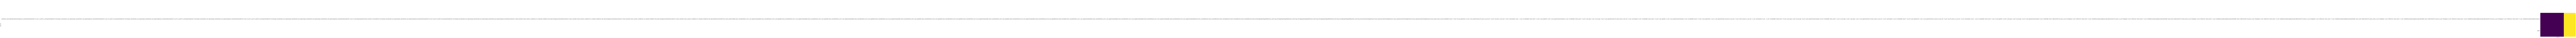

In [51]:
model.plot_attention('class34,table12,obj23,atr2') # Are you still home

Translate a few more sentences and plot them:

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [52]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1
_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_ty
peonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=
c2_at1oneparentparentinclass5_nameid=c3_at1isAbstract=No}onesigc2_at1e
xtendsc2_at1_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c
3_at3+c3_at4+c3_at5id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc
3_at1_typeonesigc3_at1extendsc3_at1_typeonesigc3_at3extendsc3_at3_type
onesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_type,onesigcla
ss4_nameextendsClassattrSet=c4_at1+c4_at2id=c4_at1noparentisAbstract=N
o}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_type,onesigc
lass5_nameextendsClassattrSet=c5_at1+c3_at1id=c5_at1noparentisAbstract
=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSe
t=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1exten
dsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3exte

#Testing existing samples

In [53]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report

In [54]:
df = pd.read_csv('po_oversample_combined_test_set 100.csv')

In [55]:
df.head()

,OM_Regular,OM_Prediction
0,moduleOM_nameonesigclass1_nameextendsClassattr...,1
1,moduleOM_nameonesigclass1_nameextendsClassattr...,1
2,moduleOM_nameonesigclass1_nameextendsClassattr...,1
3,moduleOM_nameonesigclass1_nameextendsClassattr...,1
4,moduleOM_nameonesigclass1_nameextendsClassattr...,1


In [56]:
X_test = df['OM_Regular'].values
y_test = df['OM_Prediction'].values

In [57]:
print(X_test.shape)
print(y_test.shape)

print("\nX data type: ", X_test.dtype)
print("y data type: ", y_test.dtype)

(100,)
(100,)

X data type:  object
y data type:  int64


In [58]:
print (y_test)

[1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [59]:
inputs = X_test

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [ ]:
#y_train_pred = model.predict(X_train)

In [60]:
%%time
for t in inputs:
  mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

moduleom_nameonesigclass1_nameextendsclassattrset=c1_at1+c1_at2attrset=c1_at1+c1_at2isabstract=nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassid=integerisabstract=nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsassociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsclassattrset=c3_at1oneparentparentinclass1_nameisabstract=noattrset=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,om_name_solution:0table:class1_nameattributec1_at1:c1_at1_typeprimarykeytable:class1_nameattributec1_at2:c1_at2_typetable:class2_nameattributec2_at2:c1_at2_typetable:class3_nameattributec3_at1:c3_at1_typetable:class1_nameattributec1_at1:c1_at1_typeprimarykeytable:class3_nameattributec1_at1:c1_at1_typeforeignkeytable:class3_nameparentclassclass1_nametablename:class1_nametablename:class2_nametablename:class3_nameassociationtableassoc1source:class1

# Classification Report (Existing samples)

In [65]:
dg = pd.read_csv('po_oversample_combined_test_set pred.csv')

In [66]:
X_test_pred = dg['OM_Regular'].values
y_test_pred = dg['OM_Prediction'].values

In [67]:
print (y_test_pred )

[1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
# /-----/ /--/ /-/ /--------/ /---/ /---/ 

In [68]:
precision = precision_score(y_test, y_test_pred) 
print("Training Data Precision = %f" % precision)


recall = recall_score(y_test, y_test_pred)
print("Training Data Recall = %f" % recall)





f1 = f1_score(y_test, y_test_pred)
print("Training Data F1 Score = %f" % f1)


print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_pred))

Training Data Precision = 1.000000
Training Data Recall = 0.981481
Training Data F1 Score = 0.990654

Confusion Matrix (Test Data):
 [[46  0]
 [ 1 53]]


In [69]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        46
           1       1.00      0.98      0.99        54

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



# Testing unseen samples

In [70]:
dc = pd.read_csv('unseen.csv')

In [71]:
dc.head()

,OM_Regular,OM_Prediction
0,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
1,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
2,"moduleOM_name:0,openDeclarationonesigclass1_na...",0
3,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
4,"moduleOM_name:0,openDeclarationonesigclass1_na...",1


In [72]:
X_test2 = df['OM_Regular'].values
y_test2 = df['OM_Prediction'].values

In [73]:
print(y_test2)

[1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [74]:
inputo = X_test2

In [75]:
%%time
for t in inputo:
  #mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

moduleom_nameonesigclass1_nameextendsclassattrset=c1_at1+c1_at2attrset=c1_at1+c1_at2isabstract=nonoparentonesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassid=integerisabstract=nonoparentonesigc2_at1extendsc2_at1_typeonesigc2_at1extendsc2_at1_typeonesigassoc1extendsassociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpconesigclass3_nameextendsclassattrset=c3_at1oneparentparentinclass1_nameisabstract=noattrset=c1_at1+c1_at2onesigc3_at1extendsc3_at1_typepredshowrunshowfor16,om_name_solution:0table:class1_nameattributec1_at1:c1_at1_typeprimarykeytable:class1_nameattributec1_at2:c1_at2_typetable:class2_nameattributec2_at2:c1_at2_typetable:class3_nameattributec3_at1:c3_at1_typetable:class1_nameattributec1_at1:c1_at1_typeprimarykeytable:class3_nameattributec1_at1:c1_at1_typeforeignkeytable:class3_nameparentclassclass1_nametablename:class1_nametablename:class2_nametablename:class3_nameassociationtableassoc1source:class1

# Classification Report (Unseen samples)


In [76]:
dd = pd.read_csv('unseen pred.csv')

In [77]:
dd.head()

,OM_Regular,OM_Prediction
0,moduleom_nameonesigclass1_nameextendsclassattr...,1
1,moduleom_nameonesigclass1_nameextendsclassattr...,1
2,moduleom_nameonesigclass1_nameextendsclassattr...,1
3,moduleom_nameonesigclass1_nameextendsclassattr...,1
4,moduleom_nameonesigclass1_nameextendsclassattr...,0


In [78]:
X_test_pred2 = dd['OM_Regular'].values
y_test_pred2 = dd['OM_Prediction'].values

In [80]:
print (y_test_pred2 )

[1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [81]:
precision = precision_score(y_test2, y_test_pred2) 
print("Testing: Precision = %f" % precision)


recall = recall_score(y_test2, y_test_pred2)
print("Testing: Recall = %f" % recall)


f1 = f1_score(y_test2, y_test_pred2)
print("Testing: F1 Score = %f" % f1)

print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_pred2))

Testing: Precision = 0.759259
Testing: Recall = 0.759259
Testing: F1 Score = 0.759259

Confusion Matrix (Test Data):
 [[33 13]
 [13 41]]


In [82]:
print(classification_report(y_test2,y_test_pred2))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72        46
           1       0.76      0.76      0.76        54

    accuracy                           0.74       100
   macro avg       0.74      0.74      0.74       100
weighted avg       0.74      0.74      0.74       100



# Testing unseen samples extended 





In [ ]:
dx = pd.read_csv('dummy_data_unseen_extended.csv')

In [ ]:
dx.head()

,OM_Regular,OM_Prediction
0,"table121,class221,obj31,atr1,obj32,atr2",0
1,"table122,class222,obj31,atr1,obj32,atr2",0
2,"table123,class223,obj31,atr1,obj32,atr2",0
3,"table124,class224,obj31,atr1,obj32,atr2",0
4,"table125,class225,obj31,atr1,obj32,atr2",0


In [ ]:
X_test3 = dx['OM_Regular'].values
y_test3 = dx['OM_Prediction'].values

In [ ]:
print(y_test3)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [ ]:
inputg = X_test3

In [ ]:
%%time
for t in inputg:
  #mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,a

#Classification Report (Unseen Extended samples)

In [ ]:
dy = pd.read_csv('dummy_data_unseen_undersample.csv')

In [ ]:
dy.head()

,OM_Regular,OM_Prediction
0,"table121,class221,obj31,atr1,obj32,atr2",0
1,"table122,class222,obj31,atr1,obj32,atr2",0
2,"table123,class223,obj31,atr1,obj32,atr2",0
3,"table124,class224,obj31,atr1,obj32,atr2",0
4,"table125,class225,obj31,atr1,obj32,atr2",0


In [ ]:
X_test_pred3 = dy['OM_Regular'].values
y_test_pred3 = dy['OM_Prediction'].values

In [ ]:
print (y_test_pred3)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


##ValueError: Found input variables with inconsistent numbers of samples: [122, 155]

# Testing unseen samples under samples


In [ ]:
dz = pd.read_csv('dummy_data_unseen_undersample.csv')

In [ ]:
dz.head()

,OM_Regular,OM_Prediction
0,"table121,class221,obj31,atr1,obj32,atr2",0
1,"table122,class222,obj31,atr1,obj32,atr2",0
2,"table123,class223,obj31,atr1,obj32,atr2",0
3,"table124,class224,obj31,atr1,obj32,atr2",0
4,"table125,class225,obj31,atr1,obj32,atr2",0


In [ ]:
X_test4 = dz['OM_Regular'].values
y_test4 = dz['OM_Prediction'].values

In [ ]:
print(y_test4)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
inputop = X_test4

In [ ]:
%%time
for t in inputop:
  #mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,a